In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,classification_report,roc_curve, auc
import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [50]:
'''
list_dir =glob.glob("/Users/Gaia_1/Desktop/tesi/Data after PP/*.txt")
dfs = []
for file in list_dir:
    df = pd.read_csv(file)
    dfs.append(df)
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.to_csv("PPmodeled_data.csv", index=False)
dataset=merged_df
'''

'\nlist_dir =glob.glob("/Users/Gaia_1/Desktop/tesi/Data after PP/*.txt")\ndfs = []\nfor file in list_dir:\n    df = pd.read_csv(file)\n    dfs.append(df)\nmerged_df = pd.concat(dfs, ignore_index=True)\nmerged_df.to_csv("PPmodeled_data.csv", index=False)\ndataset=merged_df\n'

In [4]:
dataset = pd.read_csv('PPmodeled_data.csv')

In [49]:
#only baseline:
#dataset = dataset[dataset['Stimulation'] != 1]

### Dropping stimulation column

In [5]:
dataset=dataset.drop(['Stimulation'],axis=1)
dataset=dataset.drop(['score'],axis=1)
dataset = dataset.drop(['Unnamed: 0'],axis=1)

In [6]:
dataset['Target'].value_counts()

1.0    543
0.0    464
Name: Target, dtype: int64

In [7]:
dataset['Target'].value_counts(1)

1.0    0.539225
0.0    0.460775
Name: Target, dtype: float64

In [8]:
X = dataset.drop(['Target'],axis=1)
y= dataset['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

# CV

In [9]:
cv = StratifiedKFold(4)

# Classification Tree

In [10]:
params = {'max_depth':np.linspace(2,10,dtype='int'),'criterion':['gini','entropy']}

clf = DecisionTreeClassifier(random_state=12)

gs_ct = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs_ct=gs_ct.fit(X_train,y_train)
y_true, y_pred = y_test, gs_ct.predict(X_test)

## CT metrics

In [11]:
print("Best parameters set found :",gs_ct.best_params_,'\n')
print("Classification report on Test set\n")

roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)

class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Best parameters set found : {'criterion': 'gini', 'max_depth': 4} 

Classification report on Test set

ROC AUC:  0.978
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       140
         1.0       0.99      0.97      0.98       163

    accuracy                           0.98       303
   macro avg       0.98      0.98      0.98       303
weighted avg       0.98      0.98      0.98       303



In [12]:
accuracy_ct = round(accuracy_score(y_true, y_pred),3)
recall_ct = round(recall_score(y_true, y_pred),3)
precision_ct = round(precision_score(y_true, y_pred),3)
roc_auc_ct = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_ct)
print('Recall: ',recall_ct)
print('Precision: ',precision_ct)
print('ROC AUC: ',roc_auc_ct)

Accuracy:  0.977
Recall:  0.969
Precision:  0.988
ROC AUC:  0.978


## CT matrix

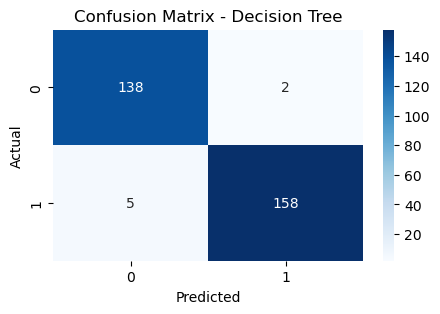

In [13]:
y_pred = gs_ct.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


## CT feature info

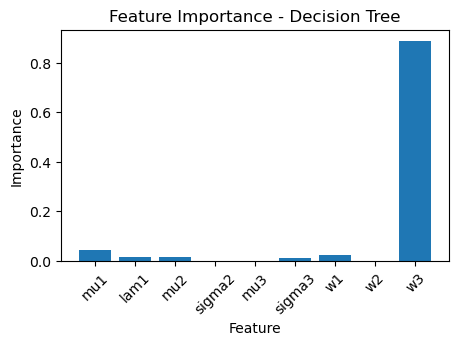

In [14]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

plt.figure(figsize=(5, 3))
plt.bar(X.columns, tree.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance - Decision Tree')
plt.xticks(rotation=45)
plt.show()


## ROC Curve

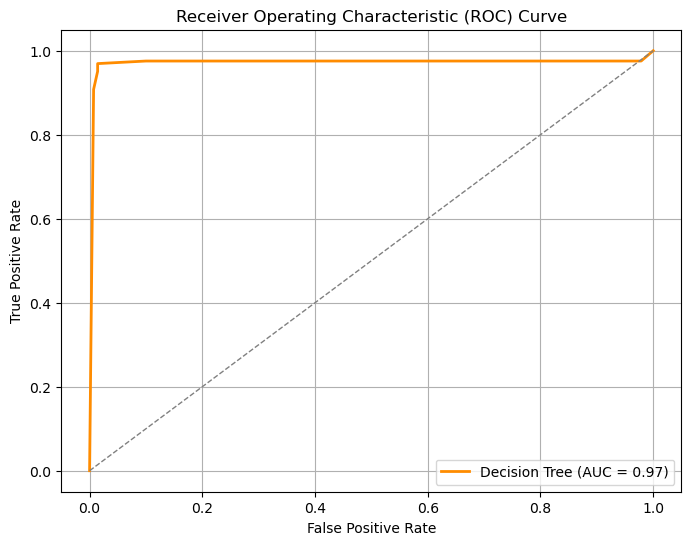

In [15]:
y_score_ct = gs_ct.predict_proba(X_test)[:,1]
fpr_ct, tpr_ct, _ = roc_curve(y_test, y_score_ct)
roc_auc_ct = auc(fpr_ct, tpr_ct)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ct, tpr_ct, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_ct:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Random Forest

In [17]:
params = {'n_estimators':[100,118,120,150],'max_depth':[3,4],'criterion':['gini','entropy']}

clf = RandomForestClassifier(n_jobs=-1,random_state=12)

gs_rf = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,verbose=0,n_jobs=-1)

gs_rf=gs_rf.fit(X_train,y_train)

## RF metrics

In [18]:
print("Best parameters set found :",gs_rf.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs_rf.predict(X_test)

roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Best parameters set found : {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 118} 

Classification report on Test set

ROC AUC:  0.978
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       140
         1.0       0.99      0.97      0.98       163

    accuracy                           0.98       303
   macro avg       0.98      0.98      0.98       303
weighted avg       0.98      0.98      0.98       303



In [19]:
y_true, y_pred = y_test, gs_rf.predict(X_test)
accuracy_rf = round(accuracy_score(y_true, y_pred),3)
recall_rf = round(recall_score(y_true, y_pred),3)
precision_rf = round(precision_score(y_true, y_pred),3)
roc_auc_rf = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_rf)
print('Recall: ',recall_rf)
print('Precision: ',precision_rf)
print('ROC AUC: ',roc_auc_rf)

Accuracy:  0.977
Recall:  0.969
Precision:  0.988
ROC AUC:  0.978


## RF matrix

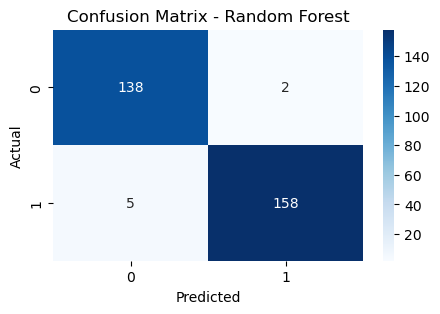

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


## RF feature info

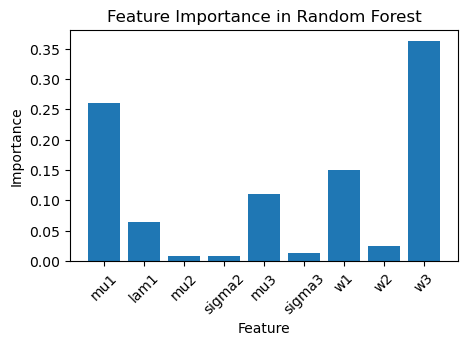

In [22]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

feature_importances = forest.feature_importances_
feature_names = X.columns
plt.figure(figsize=(5, 3))
plt.bar(feature_names, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation=45)
plt.show()


## ROC Curve

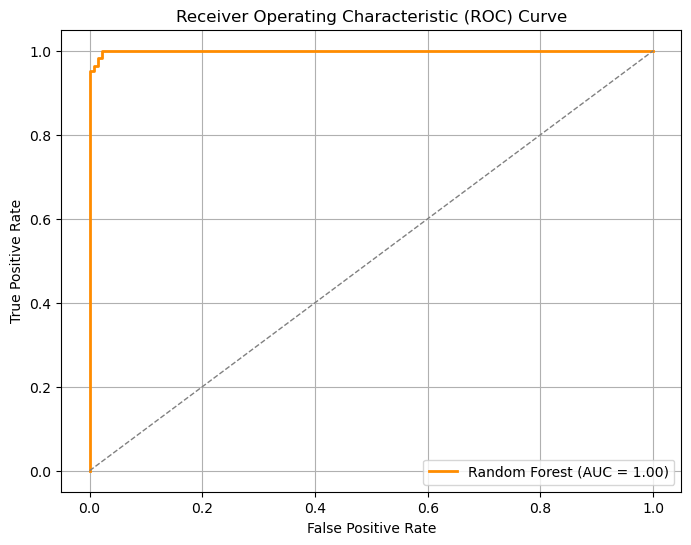

In [23]:
y_score_rf = gs_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Logistic Regression

In [24]:
params = {'C': np.logspace(-3, 3, 50), 'penalty': ['l1', 'l2']}

clf = LogisticRegression(solver='liblinear',random_state=24)

gs_logreg = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs_logreg=gs_logreg.fit(X_train,y_train)
print("Best parameters set found :",gs_logreg.best_params_,'\n')

y_true, y_pred = y_test, gs_logreg.predict(X_test)

Best parameters set found : {'C': 323.745754281764, 'penalty': 'l1'} 



## LR metrics

In [25]:
roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

ROC AUC:  0.974
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       140
         1.0       0.99      0.96      0.98       163

    accuracy                           0.97       303
   macro avg       0.97      0.97      0.97       303
weighted avg       0.97      0.97      0.97       303



In [26]:
y_true, y_pred = y_test, gs_logreg.predict(X_test)
accuracy_lr = round(accuracy_score(y_true, y_pred),3)
recall_lr = round(recall_score(y_true, y_pred),3)
precision_lr = round(precision_score(y_true, y_pred),3)
roc_auc_lr = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_lr)
print('Recall: ',recall_lr)
print('Precision: ',precision_lr)
print('ROC AUC: ',roc_auc_lr)

Accuracy:  0.974
Recall:  0.963
Precision:  0.987
ROC AUC:  0.974


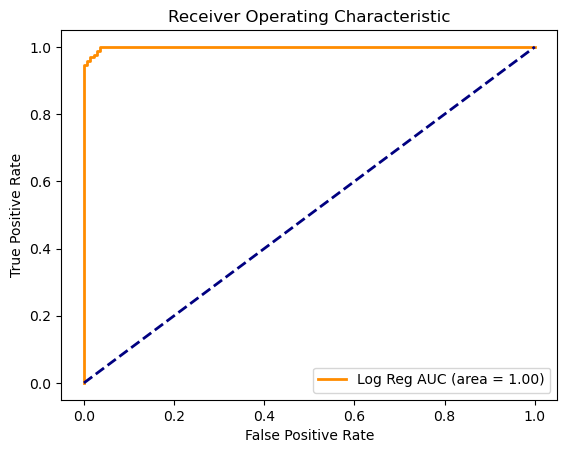

In [27]:
y_prob = gs_logreg.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Log Reg AUC (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## LR matrix

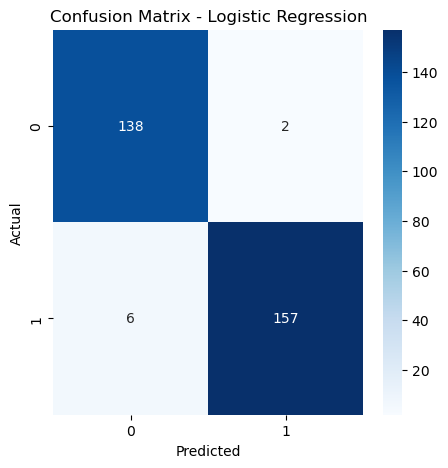

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


## LR feature info

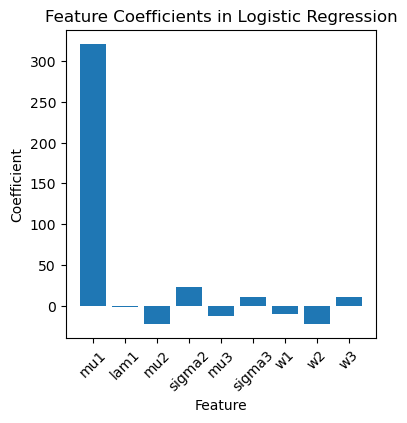

In [29]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
coefficients = gs_logreg.best_estimator_.coef_[0]
feature_names = X.columns

plt.figure(figsize=(4, 4))
plt.bar(feature_names, coefficients)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Coefficients in Logistic Regression')
plt.xticks(rotation=45)
plt.show()


# SVM

In [30]:
params = {'C': np.logspace(-3, 3, 50), 'kernel': ['linear'], 'probability': [True]}
clf = SVC(random_state=12)
gs_svm = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs=-1)
gs_svm = gs_svm.fit(X_train, y_train)
print("Best parameters set found:", gs_svm.best_params_, '\n')
y_true, y_pred = y_test, gs_svm.predict(X_test)

Best parameters set found: {'C': 568.9866029018293, 'kernel': 'linear', 'probability': True} 



In [31]:
roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

ROC AUC:  0.981
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       140
         1.0       0.99      0.97      0.98       163

    accuracy                           0.98       303
   macro avg       0.98      0.98      0.98       303
weighted avg       0.98      0.98      0.98       303



In [32]:
y_true, y_pred = y_test, gs_svm.predict(X_test)
accuracy_svm = round(accuracy_score(y_true, y_pred),3)
recall_svm = round(recall_score(y_true, y_pred),3)
precision_svm = round(precision_score(y_true, y_pred),3)
roc_auc_svm = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_svm)
print('Recall: ',recall_svm)
print('Precision: ',precision_svm)
print('ROC AUC: ',roc_auc_svm)

Accuracy:  0.98
Recall:  0.969
Precision:  0.994
ROC AUC:  0.981


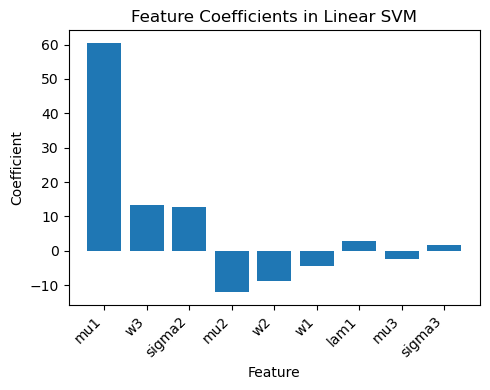

In [34]:
coefficients = gs_svm.best_estimator_.coef_[0]
feature_names = X_train.columns
feature_coefficients = list(zip(feature_names, coefficients))
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_coefficients = zip(*sorted_feature_coefficients)
plt.figure(figsize=(5, 4))
plt.bar(sorted_features, sorted_coefficients)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Coefficients in Linear SVM')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('feat_imp_SVM.jpg')
plt.show()


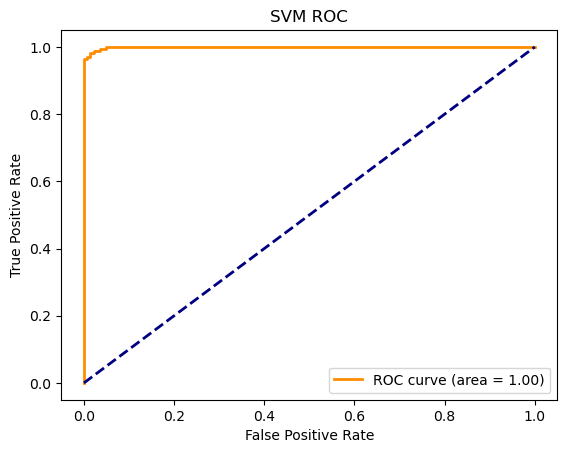

In [35]:
y_prob = gs_svm.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.legend(loc="lower right")
plt.show()

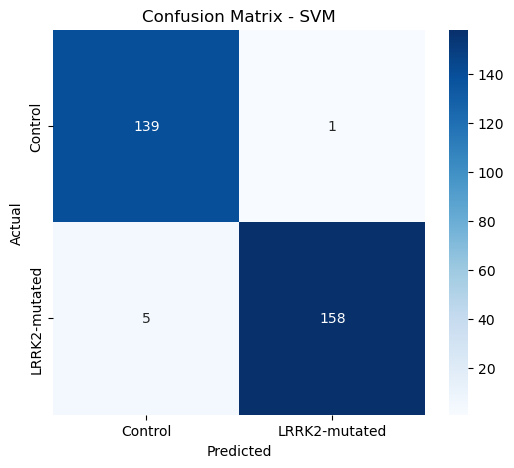

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = ['Control', 'LRRK2-mutated']

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
#plt.savefig('conf_mat_SVM.jpg')
plt.show()


# Neural Net

In [37]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            20, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

2024-06-03 17:53:01.502589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                200       
                                                                 
 dense_1 (Dense)             (None, 100)               2100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7401 (28.91 KB)
Trainable params: 7401 (28

In [38]:
metrics = [
    'accuracy',
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)



history=model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=200,
    validation_data=(X_test, y_test),

)

Epoch 1/200
71/71 [==============================] - 3s 14ms/step - loss: 0.2518 - accuracy: 0.8920 - fn: 51.0000 - fp: 25.0000 - tn: 299.0000 - tp: 329.0000 - precision: 0.9294 - recall: 0.8658 - val_loss: 0.0963 - val_accuracy: 0.9670 - val_fn: 7.0000 - val_fp: 3.0000 - val_tn: 137.0000 - val_tp: 156.0000 - val_precision: 0.9811 - val_recall: 0.9571
Epoch 2/200
71/71 [==============================] - 0s 5ms/step - loss: 0.1330 - accuracy: 0.9432 - fn: 23.0000 - fp: 17.0000 - tn: 307.0000 - tp: 357.0000 - precision: 0.9545 - recall: 0.9395 - val_loss: 0.0823 - val_accuracy: 0.9703 - val_fn: 5.0000 - val_fp: 4.0000 - val_tn: 136.0000 - val_tp: 158.0000 - val_precision: 0.9753 - val_recall: 0.9693
Epoch 3/200
71/71 [==============================] - 0s 5ms/step - loss: 0.1248 - accuracy: 0.9574 - fn: 17.0000 - fp: 13.0000 - tn: 311.0000 - tp: 363.0000 - precision: 0.9654 - recall: 0.9553 - val_loss: 0.0746 - val_accuracy: 0.9736 - val_fn: 6.0000 - val_fp: 2.0000 - val_tn: 138.0000 - va

71/71 [==============================] - 0s 6ms/step - loss: 0.0945 - accuracy: 0.9787 - fn: 10.0000 - fp: 5.0000 - tn: 319.0000 - tp: 370.0000 - precision: 0.9867 - recall: 0.9737 - val_loss: 0.0699 - val_accuracy: 0.9802 - val_fn: 6.0000 - val_fp: 0.0000e+00 - val_tn: 140.0000 - val_tp: 157.0000 - val_precision: 1.0000 - val_recall: 0.9632
Epoch 25/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1120 - accuracy: 0.9673 - fn: 13.0000 - fp: 10.0000 - tn: 314.0000 - tp: 367.0000 - precision: 0.9735 - recall: 0.9658 - val_loss: 0.0610 - val_accuracy: 0.9769 - val_fn: 3.0000 - val_fp: 4.0000 - val_tn: 136.0000 - val_tp: 160.0000 - val_precision: 0.9756 - val_recall: 0.9816
Epoch 26/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0784 - accuracy: 0.9744 - fn: 8.0000 - fp: 10.0000 - tn: 314.0000 - tp: 372.0000 - precision: 0.9738 - recall: 0.9789 - val_loss: 0.0525 - val_accuracy: 0.9769 - val_fn: 3.0000 - val_fp: 4.0000 - val_tn: 136.0000 - val_tp: 160

71/71 [==============================] - 0s 4ms/step - loss: 0.0616 - accuracy: 0.9815 - fn: 10.0000 - fp: 3.0000 - tn: 321.0000 - tp: 370.0000 - precision: 0.9920 - recall: 0.9737 - val_loss: 0.0375 - val_accuracy: 0.9835 - val_fn: 3.0000 - val_fp: 2.0000 - val_tn: 138.0000 - val_tp: 160.0000 - val_precision: 0.9877 - val_recall: 0.9816
Epoch 48/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 0.9787 - fn: 9.0000 - fp: 6.0000 - tn: 318.0000 - tp: 371.0000 - precision: 0.9841 - recall: 0.9763 - val_loss: 0.0824 - val_accuracy: 0.9604 - val_fn: 12.0000 - val_fp: 0.0000e+00 - val_tn: 140.0000 - val_tp: 151.0000 - val_precision: 1.0000 - val_recall: 0.9264
Epoch 49/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0764 - accuracy: 0.9759 - fn: 12.0000 - fp: 5.0000 - tn: 319.0000 - tp: 368.0000 - precision: 0.9866 - recall: 0.9684 - val_loss: 0.0704 - val_accuracy: 0.9637 - val_fn: 11.0000 - val_fp: 0.0000e+00 - val_tn: 140.0000 - val_tp:

71/71 [==============================] - 0s 4ms/step - loss: 0.0548 - accuracy: 0.9815 - fn: 10.0000 - fp: 3.0000 - tn: 321.0000 - tp: 370.0000 - precision: 0.9920 - recall: 0.9737 - val_loss: 0.0603 - val_accuracy: 0.9868 - val_fn: 4.0000 - val_fp: 0.0000e+00 - val_tn: 140.0000 - val_tp: 159.0000 - val_precision: 1.0000 - val_recall: 0.9755
Epoch 71/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0683 - accuracy: 0.9815 - fn: 9.0000 - fp: 4.0000 - tn: 320.0000 - tp: 371.0000 - precision: 0.9893 - recall: 0.9763 - val_loss: 0.0438 - val_accuracy: 0.9802 - val_fn: 2.0000 - val_fp: 4.0000 - val_tn: 136.0000 - val_tp: 161.0000 - val_precision: 0.9758 - val_recall: 0.9877
Epoch 72/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0802 - accuracy: 0.9787 - fn: 10.0000 - fp: 5.0000 - tn: 319.0000 - tp: 370.0000 - precision: 0.9867 - recall: 0.9737 - val_loss: 0.0518 - val_accuracy: 0.9835 - val_fn: 4.0000 - val_fp: 1.0000 - val_tn: 139.0000 - val_tp: 159.0

71/71 [==============================] - 0s 6ms/step - loss: 0.0605 - accuracy: 0.9801 - fn: 9.0000 - fp: 5.0000 - tn: 319.0000 - tp: 371.0000 - precision: 0.9867 - recall: 0.9763 - val_loss: 0.0345 - val_accuracy: 0.9835 - val_fn: 3.0000 - val_fp: 2.0000 - val_tn: 138.0000 - val_tp: 160.0000 - val_precision: 0.9877 - val_recall: 0.9816
Epoch 94/200
71/71 [==============================] - 1s 9ms/step - loss: 0.0590 - accuracy: 0.9830 - fn: 7.0000 - fp: 5.0000 - tn: 319.0000 - tp: 373.0000 - precision: 0.9868 - recall: 0.9816 - val_loss: 0.0355 - val_accuracy: 0.9901 - val_fn: 2.0000 - val_fp: 1.0000 - val_tn: 139.0000 - val_tp: 161.0000 - val_precision: 0.9938 - val_recall: 0.9877
Epoch 95/200
71/71 [==============================] - 0s 7ms/step - loss: 0.0556 - accuracy: 0.9858 - fn: 8.0000 - fp: 2.0000 - tn: 322.0000 - tp: 372.0000 - precision: 0.9947 - recall: 0.9789 - val_loss: 0.0620 - val_accuracy: 0.9769 - val_fn: 2.0000 - val_fp: 5.0000 - val_tn: 135.0000 - val_tp: 161.0000 - 

71/71 [==============================] - 0s 5ms/step - loss: 0.0521 - accuracy: 0.9872 - fn: 6.0000 - fp: 3.0000 - tn: 321.0000 - tp: 374.0000 - precision: 0.9920 - recall: 0.9842 - val_loss: 0.0517 - val_accuracy: 0.9835 - val_fn: 5.0000 - val_fp: 0.0000e+00 - val_tn: 140.0000 - val_tp: 158.0000 - val_precision: 1.0000 - val_recall: 0.9693
Epoch 117/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0834 - accuracy: 0.9730 - fn: 11.0000 - fp: 8.0000 - tn: 316.0000 - tp: 369.0000 - precision: 0.9788 - recall: 0.9711 - val_loss: 0.1402 - val_accuracy: 0.9406 - val_fn: 18.0000 - val_fp: 0.0000e+00 - val_tn: 140.0000 - val_tp: 145.0000 - val_precision: 1.0000 - val_recall: 0.8896
Epoch 118/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0596 - accuracy: 0.9730 - fn: 14.0000 - fp: 5.0000 - tn: 319.0000 - tp: 366.0000 - precision: 0.9865 - recall: 0.9632 - val_loss: 0.0430 - val_accuracy: 0.9868 - val_fn: 3.0000 - val_fp: 1.0000 - val_tn: 139.0000 - val_tp

71/71 [==============================] - 0s 4ms/step - loss: 0.0601 - accuracy: 0.9844 - fn: 8.0000 - fp: 3.0000 - tn: 321.0000 - tp: 372.0000 - precision: 0.9920 - recall: 0.9789 - val_loss: 0.0468 - val_accuracy: 0.9901 - val_fn: 2.0000 - val_fp: 1.0000 - val_tn: 139.0000 - val_tp: 161.0000 - val_precision: 0.9938 - val_recall: 0.9877
Epoch 140/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0450 - accuracy: 0.9844 - fn: 6.0000 - fp: 5.0000 - tn: 319.0000 - tp: 374.0000 - precision: 0.9868 - recall: 0.9842 - val_loss: 0.0309 - val_accuracy: 0.9901 - val_fn: 1.0000 - val_fp: 2.0000 - val_tn: 138.0000 - val_tp: 162.0000 - val_precision: 0.9878 - val_recall: 0.9939
Epoch 141/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0575 - accuracy: 0.9844 - fn: 7.0000 - fp: 4.0000 - tn: 320.0000 - tp: 373.0000 - precision: 0.9894 - recall: 0.9816 - val_loss: 0.0372 - val_accuracy: 0.9835 - val_fn: 3.0000 - val_fp: 2.0000 - val_tn: 138.0000 - val_tp: 160.0000 

71/71 [==============================] - 0s 4ms/step - loss: 0.0465 - accuracy: 0.9830 - fn: 7.0000 - fp: 5.0000 - tn: 319.0000 - tp: 373.0000 - precision: 0.9868 - recall: 0.9816 - val_loss: 0.0391 - val_accuracy: 0.9868 - val_fn: 2.0000 - val_fp: 2.0000 - val_tn: 138.0000 - val_tp: 161.0000 - val_precision: 0.9877 - val_recall: 0.9877
Epoch 163/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0525 - accuracy: 0.9858 - fn: 6.0000 - fp: 4.0000 - tn: 320.0000 - tp: 374.0000 - precision: 0.9894 - recall: 0.9842 - val_loss: 0.0435 - val_accuracy: 0.9835 - val_fn: 1.0000 - val_fp: 4.0000 - val_tn: 136.0000 - val_tp: 162.0000 - val_precision: 0.9759 - val_recall: 0.9939
Epoch 164/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0475 - accuracy: 0.9815 - fn: 9.0000 - fp: 4.0000 - tn: 320.0000 - tp: 371.0000 - precision: 0.9893 - recall: 0.9763 - val_loss: 0.0359 - val_accuracy: 0.9835 - val_fn: 2.0000 - val_fp: 3.0000 - val_tn: 137.0000 - val_tp: 161.0000 

71/71 [==============================] - 0s 4ms/step - loss: 0.0506 - accuracy: 0.9886 - fn: 6.0000 - fp: 2.0000 - tn: 322.0000 - tp: 374.0000 - precision: 0.9947 - recall: 0.9842 - val_loss: 0.0449 - val_accuracy: 0.9835 - val_fn: 3.0000 - val_fp: 2.0000 - val_tn: 138.0000 - val_tp: 160.0000 - val_precision: 0.9877 - val_recall: 0.9816
Epoch 186/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0542 - accuracy: 0.9844 - fn: 7.0000 - fp: 4.0000 - tn: 320.0000 - tp: 373.0000 - precision: 0.9894 - recall: 0.9816 - val_loss: 0.0541 - val_accuracy: 0.9670 - val_fn: 9.0000 - val_fp: 1.0000 - val_tn: 139.0000 - val_tp: 154.0000 - val_precision: 0.9935 - val_recall: 0.9448
Epoch 187/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0493 - accuracy: 0.9815 - fn: 9.0000 - fp: 4.0000 - tn: 320.0000 - tp: 371.0000 - precision: 0.9893 - recall: 0.9763 - val_loss: 0.0662 - val_accuracy: 0.9703 - val_fn: 9.0000 - val_fp: 0.0000e+00 - val_tn: 140.0000 - val_tp: 154.0

dict_keys(['loss', 'accuracy', 'fn', 'fp', 'tn', 'tp', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_fn', 'val_fp', 'val_tn', 'val_tp', 'val_precision', 'val_recall'])


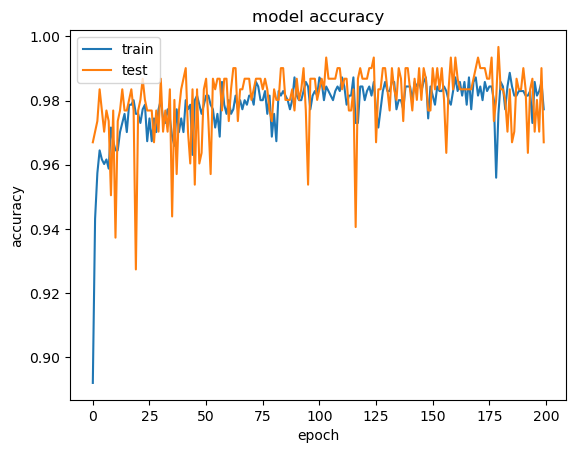

In [39]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
y_pred_probabilities = model.predict(X_test)
threshold = 0.5
y_pred = (y_pred_probabilities > threshold).astype(int)
y_true= y_test

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)

10/10 [==============================] - 0s 2ms/step
Accuracy:  0.967
Recall:  0.939
Precision:  1.0
ROC AUC:  0.969


In [41]:
np.shape(y_pred_probabilities)

(303, 1)

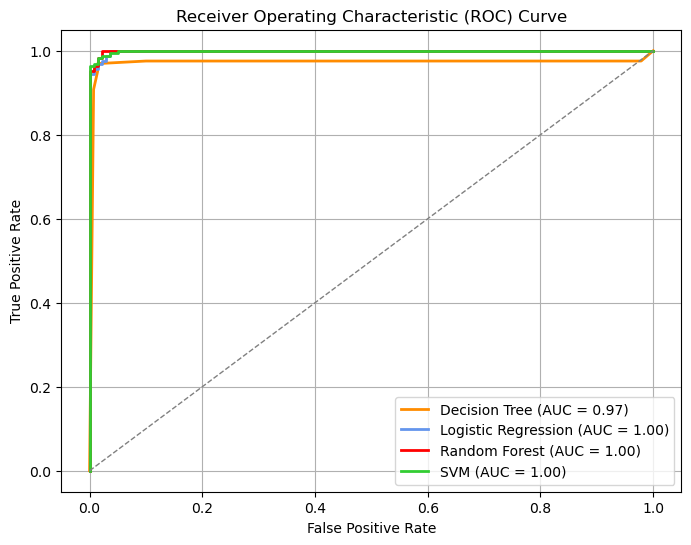

In [42]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ct, tpr_ct, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_ct:.2f})')
plt.plot(fpr_lr, tpr_lr, color='cornflowerblue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='limegreen', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
#plt.plot(fpr_lr, tpr_lr, color='cornflowerblue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('all_ROC.jpg')
plt.show()

In [43]:
print('Decision Tree: ')
print('Accuracy: ',accuracy_ct)
print('Recall: ',recall_ct)
print('Precision: ',precision_ct)
print('ROC AUC: ',roc_auc_ct)

print('Logistic Regression')
print('Accuracy: ',accuracy_lr)
print('Recall: ',recall_lr)
print('Precision: ',precision_lr)
print('ROC AUC: ',roc_auc_lr)


print('Random Forest')
print('Accuracy: ',accuracy_rf)
print('Recall: ',recall_rf)
print('Precision: ',precision_rf)
print('ROC AUC: ',roc_auc_rf)

print('Support Vector Machine: ')
print('Accuracy: ',accuracy_svm)
print('Recall: ',recall_svm)
print('Precision: ',precision_svm)
print('ROC AUC: ',roc_auc_svm)


Decision Tree: 
Accuracy:  0.977
Recall:  0.969
Precision:  0.988
ROC AUC:  0.9714066608238388
Logistic Regression
Accuracy:  0.974
Recall:  0.963
Precision:  0.987
ROC AUC:  0.9988168273444348
Random Forest
Accuracy:  0.977
Recall:  0.969
Precision:  0.988
ROC AUC:  0.9992550394390886
Support Vector Machine: 
Accuracy:  0.98
Recall:  0.969
Precision:  0.994
ROC AUC:  0.9991235758106923


In [44]:
print('Decision Tree: ',accuracy_ct)
print('Logistic Regression',accuracy_lr)
print('Random Forest',accuracy_rf)
print('-->> Support Vector Machine: ',accuracy_svm)

Decision Tree:  0.977
Logistic Regression 0.974
Random Forest 0.977
-->> Support Vector Machine:  0.98


In [45]:
print('Decision Tree: ',recall_ct)
print('Logistic Regression',recall_lr)
print('Random Forest',recall_rf)
print('-->> Support Vector Machine: ',recall_svm)


Decision Tree:  0.969
Logistic Regression 0.963
Random Forest 0.969
-->> Support Vector Machine:  0.969


In [46]:
print('Decision Tree: ',precision_ct)
print('Logistic Regression',precision_lr)
print('Random Forest',precision_rf)
print('-->>    Support Vector Machine: ',precision_svm)


Decision Tree:  0.988
Logistic Regression 0.987
Random Forest 0.988
-->>    Support Vector Machine:  0.994


In [47]:
print('Decision Tree: ',roc_auc_ct)
print('Logistic Regression',roc_auc_lr)
print('Random Forest',roc_auc_rf)
print('-->> Support Vector Machine: ',roc_auc_svm)


Decision Tree:  0.9714066608238388
Logistic Regression 0.9988168273444348
Random Forest 0.9992550394390886
-->> Support Vector Machine:  0.9991235758106923
